In [1]:
# imports
from nibabel.testing import data_path
import numpy as np
import tensorflow as tf
from keras import applications
import nibabel as nib
import keras
import os
import pandas as pd
import re
import math

In [2]:
# enable GPU
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13206649871423337673
xla_global_id: -1
]


In [4]:
# import keras required libs.
import matplotlib.pyplot as plt
import glob
from keras.losses import categorical_crossentropy
from keras.models import Sequential, Model 
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras import layers
from sklearn.model_selection import train_test_split

In [5]:
# bringing in dataframes
df = pd.read_csv('OASIS4_data_clinical.csv')
neuro = pd.read_csv('OASIS4_data_Neuropsychometric.csv')

In [6]:
neuro = neuro[['oasis_id','short_blessed']]
for i in range(len(neuro['oasis_id'])):
    if isinstance(neuro['short_blessed'][i], str):
        if (neuro['short_blessed'][i].isnumeric()):
            neuro.at[i,'short_blessed']=int(neuro['short_blessed'][i])
        else:
            neuro = neuro.drop(labels=i, axis=0)
    elif math.isnan(neuro['short_blessed'][i]):
        neuro = neuro.drop(labels=i, axis=0)
neuro = neuro.reset_index(drop=True)
for i in range(len(neuro['oasis_id'])-1):
    if neuro['oasis_id'][i] == neuro['oasis_id'][i+1]:
        neuro = neuro.drop(labels=i, axis=0)
neuro = neuro.reset_index(drop=True)
#for i in range(len(neuro['oasis_id'])):
#    if 

In [7]:
# Regex
pattern = r"\d{5}"

In [8]:
# fetch the files we need.
filename_list = []
for name in glob.glob('./NIIs only TEST/*.nii.gz'):
    filename_list.append(name)
# Dealing with missing images/ clinical entries
x=0
while x < len(filename_list):
    if "run-01" in filename_list[x] or "run-03" in filename_list[x] or "run-04" in filename_list[x] or "run-05" in filename_list[x]:
        os.remove(filename_list[x])
        filename_list.pop(x)
    x+=1
print(x)

131


In [9]:
x=0
while x < len(filename_list):
    match = re.search(pattern, filename_list[x])
    file_num = match.group(0)
    match = re.search(pattern, df['oasis_id'][x])
    clinical_num = match.group(0)
    if (int(file_num) < int(clinical_num)):
        os.remove(filename_list[x])
        filename_list.pop(x)
    elif (int(file_num) > int(clinical_num)):
        df = df.drop(labels=x, axis=0)
        df = df.reset_index(drop=True)
    x+=1
print(x)

131


In [10]:
# test if worked. if it prints anything then it didnt work.
for x in range(len(filename_list)):
    if df['oasis_id'][x] in filename_list[x]:
        df = df.drop(labels=x, axis=0)
        neuro = neuro.drop(labels=x, axis=0)
    else:
        print(x)
        print(df['oasis_id'][x])
        print(filename_list[x])
        break
print(len(neuro['oasis_id']))


525


In [11]:
# test if worked. if it prints anything then it didnt work.
x=0
df = df.reset_index(drop=True)
neuro = neuro.reset_index(drop=True)
while x < (len(df['oasis_id'])) and x < len(neuro['oasis_id']):
    match = re.search(pattern, neuro['oasis_id'][x])
    neuro_num = match.group(0)
    match = re.search(pattern, df['oasis_id'][x])
    clinical_num = match.group(0)
    if (int(neuro_num) < int(clinical_num)):
        neuro = neuro.drop(labels=x, axis=0)
        neuro = neuro.reset_index(drop=True)
    elif (int(neuro_num) > int(clinical_num)):
        df = df.drop(labels=x, axis=0)
        df = df.reset_index(drop=True)
    x+=1

for i in range(len(df['oasis_id'])):
    if df['oasis_id'][i] == neuro['oasis_id'][i]:
        continue
    else:
        print(i)
        print(df['oasis_id'][i])
        break


In [12]:
# Cutting the tail values we don't need and making a
# column of the corresponding images.
df = df.iloc[:-(df.shape[0]-len(filename_list))]
neuro = neuro.iloc[:-(neuro.shape[0]-len(filename_list))] 
df['image_path'] = filename_list
df.shape[0]
df.tail()
df.to_csv('cleaned.csv')
print(len(df['oasis_id']))
print(len(neuro['oasis_id']))
df.head()

131
131


,oasis_id,demographics_id,demographics_firstvisit,sex,age,edu,race,hispanic,marriage,declong,...,health_history4,health_history5,health_history6,health_history7,health_history10,health_history11,health_history12,final_dx,final_dx_categorized,image_path
0,OAS42151,OAS42151_demographics_d3000,0,1,75,2,1,0,1,3.0,...,0,0,0,0,0,0,0,Alzheimer Disease Dementia,1,./NIIs only TEST\sub-OAS42000_sess-d3016_T2w.n...
1,OAS42152,OAS42152_demographics_d3000,0,2,68,3,1,0,1,1.0,...,0,0,0,0,0,0,0,Alzheimer Disease Dementia,1,./NIIs only TEST\sub-OAS42001_sess-d3006_T2w.n...
2,OAS42153,OAS42153_demographics_d3000,0,1,76,3,1,0,1,25.0,...,0,0,0,0,0,0,0,Uncertain - AD possible,8,./NIIs only TEST\sub-OAS42002_sess-d3018_T2w.n...
3,OAS42154,OAS42154_demographics_d3000,0,1,68,2,2,0,1,1.0,...,0,0,0,0,0,0,0,Uncertain - AD possible,8,./NIIs only TEST\sub-OAS42003_sess-d3042_run-0...
4,OAS42156,OAS42156_demographics_d3000,0,1,59,4,1,0,1,7.0,...,0,0,0,0,0,0,0,Cognitively Normal,0,./NIIs only TEST\sub-OAS42004_sess-d3015_T2w.n...


In [13]:
dx_keep = [0,1,2]
for i in range(df.shape[0]-1):
    if df['final_dx_categorized'][i] not in dx_keep:
        df = df.drop(labels=i, axis=0)
        neuro = neuro.drop(labels=i, axis=0)
df = df.reset_index(drop=True)
neuro = neuro.reset_index(drop=True)
print(neuro.shape)
print(df.shape)

(71, 2)
(71, 28)


In [14]:
df = df[['oasis_id','age','declong','final_dx_categorized','image_path']]
neuro = neuro[['short_blessed']]
clinical = pd.concat([df, neuro], axis=1, join='inner')
display(df)
print(type(df['declong'][0]))
display

,oasis_id,age,declong,final_dx_categorized,image_path
0,OAS42151,75,3.00,1,./NIIs only TEST\sub-OAS42000_sess-d3016_T2w.n...
1,OAS42152,68,1.00,1,./NIIs only TEST\sub-OAS42001_sess-d3006_T2w.n...
2,OAS42156,59,7.00,0,./NIIs only TEST\sub-OAS42004_sess-d3015_T2w.n...
3,OAS42158,84,3.00,1,./NIIs only TEST\sub-OAS42007_sess-d3492_T2w.n...
4,OAS42159,71,1.00,1,./NIIs only TEST\sub-OAS42009_sess-d2904_T2w.n...
...,...,...,...,...,...
66,OAS42285,82,3.00,1,./NIIs only TEST\sub-OAS42144_sess-d3014_T2w.n...
67,OAS42286,66,2.00,0,./NIIs only TEST\sub-OAS42145_sess-d3021_T2w.n...
68,OAS42287,76,1.50,1,./NIIs only TEST\sub-OAS42146_sess-d3504_T2w.n...
69,OAS42289,84,0.66,1,./NIIs only TEST\sub-OAS42148_sess-d3022_T2w.n...


<class 'numpy.float64'>


<function IPython.core.display_functions.display(*objs, include=None, exclude=None, metadata=None, transient=None, display_id=None, raw=False, clear=False, **kwargs)>

In [15]:
# Label the images
cn_x = []
cn_y = []
ad_x = []
ad_y = []
mci_x = []
mci_y = []
total_data_x = []
total_data_y = []
chosen_images = []
for i in range(df.shape[0]):
    if df['final_dx_categorized'][i] == 0:
        newimg = nib.load(df['image_path'][i])
        data = newimg.get_fdata()
        if data.shape==(320,320,28):
            clinical_values = [df['age'][i], df['declong'][i], neuro['short_blessed'][i]]
            reshaped_values = np.array(clinical_values).reshape((1, 1, 3))
            resized_array = np.resize(reshaped_values, (320, 320, 3))
            result = np.concatenate((data, resized_array), axis=2)
            cn_x.append(result)
            cn_y.append(0)
            chosen_images.append(df['oasis_id'][i])
    elif df['final_dx_categorized'][i] == 1:
        newimg = nib.load(df['image_path'][i])
        data = newimg.get_fdata()
        if data.shape==(320,320,28):
            clinical_values = [df['age'][i], df['declong'][i], neuro['short_blessed'][i]]
            reshaped_values = np.array(clinical_values).reshape((1, 1, 3))
            resized_array = np.resize(reshaped_values, (320, 320, 3))
            result = np.concatenate((data, resized_array), axis=2)
            ad_x.append(result)
            ad_y.append(1)
            chosen_images.append(df['oasis_id'][i])
    elif df['final_dx_categorized'][i] == 2:
        newimg = nib.load(df['image_path'][i])
        data = newimg.get_fdata()
        if data.shape==(320,320,28):
            clinical_values = [df['age'][i], df['declong'][i], neuro['short_blessed'][i]]
            reshaped_values = np.array(clinical_values).reshape((1, 1, 3))
            resized_array = np.resize(reshaped_values, (320, 320, 3))
            result = np.concatenate((data, resized_array), axis=2)
            mci_x.append(result)
            mci_y.append(2)
            chosen_images.append(df['oasis_id'][i])
for i in range(len(cn_x)):
    total_data_x.append(cn_x[i])
    total_data_y.append(cn_y[i])
for i in range(len(ad_x)):
    total_data_x.append(ad_x[i])
    total_data_y.append(ad_y[i])
for i in range(len(mci_x)):
    total_data_x.append(mci_x[i])
    total_data_y.append(mci_y[i])
# Cut out from neuro set:

for i in range(len(total_data_x)):
    print(total_data_x[i].shape)
print(len(total_data_x))

(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
(320, 320, 31)
30


In [16]:
newdata=np.array(total_data_x, dtype=object)
print(type(newdata))
print(newdata.shape)
zeros_array = np.zeros((30, 320, 320, 1))
newdata = np.concatenate((newdata, zeros_array), axis=3)
print(newdata.shape)
maindata=np.stack([newdata]*3, axis=-1)
maindata=maindata.reshape(len(total_data_x)*320,320,32,3)

<class 'numpy.ndarray'>
(30, 320, 320, 31)
(30, 320, 320, 32)


In [17]:
new_y=[]
for i in range (len(total_data_x)):
    for j in range(320):
        new_y.append(total_data_y[i])
new_y=np.array(new_y)

In [18]:
maindata.shape,new_y.shape

((9600, 320, 32, 3), (9600,))

In [20]:
# splitting data for train and test 70:30.
X_train, X_test, y_train, y_test = train_test_split(maindata, new_y, test_size=0.33)

X_train=np.array(X_train)
y_train=np.array(y_train)
x_train = X_train.reshape(X_train.shape[0], 320, 32, 3)

input_shape = (320,32,3)
x_train = x_train.astype('float32')
y_train = keras.utils.to_categorical(y_train)
y_old_test=y_test
y_test = keras.utils.to_categorical(y_test)


In [21]:
# Using ResNet50

model = applications.ResNet50(weights = "imagenet", include_top=False, input_shape=input_shape)


# Freeze the layers which you don't want to train. Here I am not freezing any layer.
for layer in model.layers:
    layer.trainable = True
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation="softmax")(x)
model= Model(model.input, predictions)

In [22]:
# Compile and Train:
model.compile(keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
val=model.fit(x=x_train,y=y_train,batch_size=64, epochs=10,validation_split=0.1)

Epoch 1/10
91/91 [==============================] - 506s 6s/step - loss: 1.5165 - accuracy: 0.5674 - val_loss: 0.9708 - val_accuracy: 0.6335
Epoch 2/10
91/91 [==============================] - 531s 6s/step - loss: 0.8490 - accuracy: 0.6811 - val_loss: 0.8323 - val_accuracy: 0.6724
Epoch 3/10
91/91 [==============================] - 565s 6s/step - loss: 0.6110 - accuracy: 0.7600 - val_loss: 0.7543 - val_accuracy: 0.6848
Epoch 4/10
91/91 [==============================] - 614s 7s/step - loss: 0.4825 - accuracy: 0.8067 - val_loss: 0.7200 - val_accuracy: 0.7158
Epoch 5/10
91/91 [==============================] - 634s 7s/step - loss: 0.4030 - accuracy: 0.8412 - val_loss: 0.5238 - val_accuracy: 0.8043
Epoch 6/10
91/91 [==============================] - 674s 7s/step - loss: 0.3161 - accuracy: 0.8782 - val_loss: 0.4300 - val_accuracy: 0.8137
Epoch 7/10
91/91 [==============================] - 648s 7s/step - loss: 0.2662 - accuracy: 0.8960 - val_loss: 0.3323 - val_accuracy: 0.8665
Epoch 8/10
91

In [25]:
X_test=np.array(X_test)
x_test = X_test.reshape(X_test.shape[0],320,32,3)
x_test = x_test.astype('float32')
    # Normalizing the RGB codes by dividing it to the max RGB value.
print('Number of images in x_test', x_test.shape[0])
model.evaluate(x_test,y_test)


Number of images in x_test 3168
99/99 [==============================] - 29s 296ms/step - loss: 0.2852 - accuracy: 0.8867


[0.28516796231269836, 0.8866792917251587]

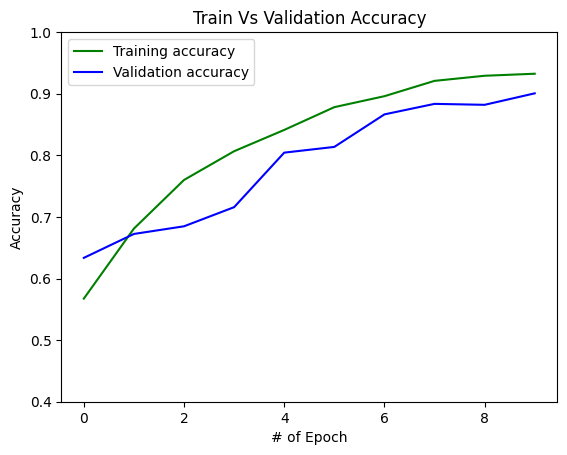

In [26]:
plt.plot(val.history['accuracy'], color='g')
plt.plot(val.history['val_accuracy'], color='b')
plt.legend(['Training accuracy' ,'Validation accuracy'])
plt.title("Train Vs Validation Accuracy")
plt.xlabel("# of Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.40,1)
plt.show()